# Gridworld Plot

Uncomment the following cells (by deleting the leading `#`) if you are running this in Colab.

In [ ]:
# !git clone https://github.com/wbarfuss/POLD.git

In [ ]:
# cd POLD

In [1]:
# imports
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from agents.deterministic import detQ
from environments.Env_ParrRusselGridWorld import ParrRusselGridWorld as ENV,\
    states, actions

from utils import interact as ia
from utils import histories as he

# document this session for reproducibility
import IPython
print(IPython.sys_info())
print()
print('PACKAGES')
print('----- pip -----')
!pip freeze | grep -E 'numpy|scipy|pandas|matplotlib|ipython|pyDOE'
print('----- conda -----')
!conda list --export | grep -E 'numpy|scipy|pandas|matplotlib|ipython|pyDOE'

{'commit_hash': '8648ed8d7',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/Users/wolf/.miniconda3/envs/RRL/lib/python3.9/site-packages/IPython',
 'ipython_version': '7.22.0',
 'os_name': 'posix',
 'platform': 'macOS-10.16-x86_64-i386-64bit',
 'sys_executable': '/Users/wolf/.miniconda3/envs/RRL/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.9.5 (default, May 18 2021, 12:31:01) \n[Clang 10.0.0 ]'}

PACKAGES
----- pip -----
ipython @ file:///opt/concourse/worker/volumes/live/53a0fafb-1ff1-44d4-4ba9-874c42807e28/volume/ipython_1617120878135/work
ipython-genutils @ file:///tmp/build/80754af9/ipython_genutils_1606773439826/work
matplotlib @ file:///opt/concourse/worker/volumes/live/41e8cd50-031f-4dda-5787-dd3c4f4e0f08/volume/matplotlib-suite_1613407855571/work
numpy==1.22.2
pandas==1.4.1
pyDOE==0.3.8
scipy==1.8.0
----- conda -----
ipython=7.22.0=py39h01d92e1_0
ipython_genutils=0.2.0=pyhd3eb1b0_1
matplotlib=3.3.4=py39hecd8cb5_0
matplotlib-base=

In [2]:
# helpers
def setup_agents(AGENTS, alpha, beta, gamma,
                 ENV, observe="partial", Rpen=0., Aerr=0.0, h=(1,0)):
    
    env = ENV(action_error_rate=Aerr, reward_step_penalty=Rpen, observe=observe)
    
    T = env.TransitionTensor(); assert np.allclose(T.sum(-1), 1)
    O = env.ObservationTensor(); assert np.allclose(O.sum(-1), 1)
    R = env.RewardTensor()
    FS = np.zeros(env.Z, dtype=int); FS[-2:] = 1
    agents = AGENTS(T, R, O, alpha, beta, gamma, FinalStates=FS)
    
    fid = f"{ENV.__name__}_{observe}_{Aerr}_{Rpen}__"\
    + f"{AGENTS.__name__}_{np.round(alpha, 3)}_{np.round(beta,3)}_{gamma}"
    
    if h != (1,0):
        T = he.histSjA_TransitionTensor(env, h)
        R = he.histSjA_RewardTensor(env, h)
        O = he.histSjA_ObservationTensor(env, h)
        print(R.shape, O.shape)
        assert np.allclose(T.sum(-1), 1)
        assert np.allclose(O.sum(-1), 1)
        agents = AGENTS(T, R, O, alpha, beta, gamma)    

        fid = f"{ENV.__name__}_{observe}_{Aerr}_{Rpen}_{h}__"\
            + f"{AGENTS.__name__}_{np.round(alpha, 3)}_{np.round(beta,3)}_{gamma}"

    print("Setup ", fid)

    return agents, fid

def getXs(agents):
    Xs = []
    
    for a in range(4):
        X = agents.zeroIntelligence_behavior()
        for c in range(X.shape[1]):
            X[0, c, a] = 0.9
            for b in set(range(4)) - {a}:
                X[0, c, b] = 0.1
            
        Xs.append(X)
    return Xs

def compute_data(agents, SampSize):
    if SampSize < 2:
        Xs = [agents.zeroIntelligence_behavior() for _ in range(1)]  
    elif SampSize ==4:
        Xs = getXs(agents)
    else:  
        Xs = [agents.random_behavior() for _ in range(SampSize)]
    Xtrajs, Rtrajs, fprs = [], [], []
    for i in range(len(Xs)):
        print(' ', i, end='')
        X = Xs[i]
        Xtraj, Rtraj, fpr = ia.compute_detXtraj(agents, X, EpsMin=1e-5,
                                                Tmax=15000)
        if not fpr:
            print("FP not reached")
        Xtrajs.append(Xtraj); Rtrajs.append(Rtraj); fprs.append(fpr)
    print()
    return dict(X=Xtrajs, R=Rtrajs, fp=fprs)

def get_data(agents, agentid, SampSize, datfolder=None):

    try:
        fn = agentid + f"__{SampSize}.npz"
        if datfolder is not None:
            fn = os.path.expanduser(datfolder) + fn
        dat = np.load(fn, allow_pickle=True)
        ddic = dict(zip((k for k in dat), (dat[k] for k in dat)))
        print(f"Loading {fn}")
    
    except:
        print(f"Computing {fn}")
        ddic = compute_data(agents, SampSize)
        if datfolder is not None:
            np.savez_compressed(fn, **ddic)
            
    return ddic

def plot_obs(Xtraj, i, o, ax, color, alpha, linstyle="-", lw=2):
    e = Xtraj[:,i,o,0]; w = Xtraj[:,i,o,1]
    n = Xtraj[:,i,o,2]; s = Xtraj[:,i,o,3]
    h = e+w; v = n+s
    
    alph = 0.5
    xweight = h**alph; yweight = v**alph
    x = xweight * (e / h) + (0.5 - 0.5*xweight)
    y = yweight * (n / v) + (0.5 - 0.5*yweight)

    ax.plot(x, y, alpha=alpha, color=color, linestyle=linstyle, lw=lw)
    ax.scatter(x[-1], y[-1], marker=".", s=lw*20, alpha=alpha/2, color=color,
               zorder=4)
    
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels([]); ax.set_yticklabels([])
        
def compute_hyperparamgrid(gams, bets, SampSize, obs="partial", h=(1,0),
                           datfolder=None, alpha=0.1):
    index = pd.MultiIndex.from_product([gams, bets], names=["gam", "bet"])
    df = pd.DataFrame(index=index, columns=['rmean', 'rstd', 'lmean', 'lstd'])

    fn = f'data/GridWorldParameterGrid_bets{bets}_gams{gams}_SaSi{SampSize}' +\
        f'_obs{obs}_hist{h}.pkl'

    try: 
        df = pd.read_pickle(fn)
        print("LOADING", fn)

    except:
        print("COMPUTING", fn)
        for bet in bets:
            for gam in gams:
                print(" = = = = bet: ", bet, "  gam: ", gam, " = = = =")
                
                gamma = gam
                beta = bet / (1-gamma)
                alpha = alpha #  .5 / ((1-gamma) * beta)
                agent, fid = setup_agents(detQ, alpha, beta, gamma, ENV,
                                          observe=obs, Aerr=0.0, Rpen=0.0, h=h) 
                ddic = get_data(agent, fid, SampSize, datfolder)
                
                Rtrajs = ddic["R"]
                df.loc[(gam,bet),'rmean']= np.mean([r[-1,0] for r in Rtrajs])
                df.loc[(gam,bet),'rstd'] = np.std([r[-1,0] for r in Rtrajs])
                df.loc[(gam,bet),'lmean']= np.mean([r.shape[0] for r in Rtrajs])
                df.loc[(gam,bet),'lstd'] = np.std([r.shape[0] for r in Rtrajs])
        df.to_pickle(fn)
    return df     

def aux_plot_grid(df, what='rmean', ax=None, bar=True,
                  vmax=None, vmin=None, cmap='viridis'):
    
    dfus = df[what].astype(float).unstack()
    if ax is None:
        cbar = plt.imshow(dfus, vmax=vmax, vmin=vmin, cmap=cmap)
        ax = plt.gca()
    else:
        cbar = ax.imshow(dfus)
    ax.set_xticks(range(len(dfus.columns)))
    ax.set_xticklabels(list(dfus.columns))
    ax.set_xlabel(dfus.columns.name)
    ax.set_yticks(range(len(dfus.index)))
    ax.set_yticklabels(list(dfus.index))
    ax.set_ylabel(dfus.index.name)
    ax.set_title(what)
    if bar:
        cb = plt.gcf().colorbar(cbar, ax=ax)
        return cb
    

## Plot 1

Setup  ParrRusselGridWorld_full_0.0_0.0__detQ_0.01_5000.0_0.99
Computing ParrRusselGridWorld_full_0.0_0.0__detQ_0.01_5000.0_0.99__3.npz
  0  1  2
Setup  ParrRusselGridWorld_full_0.0_0.0__detQ_0.01_33.333_0.4
Computing ParrRusselGridWorld_full_0.0_0.0__detQ_0.01_33.333_0.4__3.npz
  0  1  2
Setup  ParrRusselGridWorld_partial_0.0_0.0__detQ_0.01_5000.0_0.99
Computing ParrRusselGridWorld_partial_0.0_0.0__detQ_0.01_5000.0_0.99__3.npz
  0  1  2
Setup  ParrRusselGridWorld_partial_0.0_0.0__detQ_0.01_33.333_0.4
Computing ParrRusselGridWorld_partial_0.0_0.0__detQ_0.01_33.333_0.4__3.npz
  0  1  2
Average reward  navy 0.24324176024595082
Average reward  navy 0.12924318344027005
Average reward  navy 0.0033575663346841985
Average reward  navy 0.014415786429136145
LOADING data/GridWorldParameterGrid_bets[1, 5, 10, 15, 20, 25, 50, 100]_gams[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]_SaSi15_obspartial_hist(1, 0).pkl
LOADING data/GridWorldParameterGrid_bets[1, 5, 10, 15, 20, 25, 50, 100]_ga

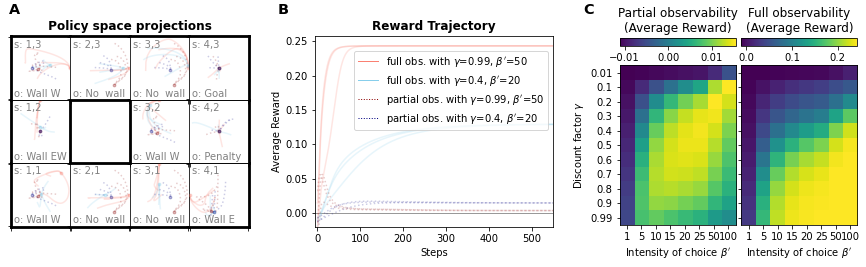

In [3]:
# PARAMETERS
datfolder = None  # to store computed results for faster plotting

gams = [0.99, 0.4, 0.99, 0.4]
bets = [50, 20, 50, 20]
obss = ['full', 'full', 'partial', 'partial']
cols = ['salmon', 'skyblue', 'darkred', 'navy']
lins = [ '-', '-', ':', ':']
SaSi = 3 # SampleSize: Here only a small one for inspection

# DATA GENERATION
ddics = []
agens = {}
for gam, bet, obs, col, lin in list(zip(gams, bets, obss, cols, lins)):       
    gamma = gam
    beta = bet / (1-gamma)
    alpha = 0.01
    
    agent, fid = setup_agents(detQ, alpha, beta, gamma,
                              ENV, observe=obs, Aerr=0.0, Rpen=0.0)
    ddic = get_data(agent, fid, SaSi, datfolder)
    ddics.append(ddic)
    agens[obs] = agent
            
            
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
#   THE PLOT
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
fsf = 1.0
fig = plt.figure(figsize=(fsf*12, fsf*3.5))

gs = fig.add_gridspec(1, 3, wspace=0.28, left=0.01, right=0.99)
gsPS = gs[0].subgridspec(3, 4, wspace=0.0, hspace=0.0)
axTR = fig.add_subplot(gs[1])
gsHP = gs[2].subgridspec(1,2, wspace=0.1)

# POLICY SPACE PROJECTIONS
for i in range(4):
    for j in range(3):
        if (i,j) in states:
            ax = fig.add_subplot(gsPS[2-j, i])
            
            if 'partial' in agens:
                o = agens['partial'].O[0, states.index((i,j))].argmax()
                ostr = ""
                ostr += "Wall W" if o==0 else ""
                ostr += "Wall E" if o==1 else ""
                ostr += "No  wall" if o==2 else ""
                ostr += "Wall EW" if o==3 else ""
                ostr += "Penalty" if o==4 else ""
                ostr += "Goal" if o==5 else ""
            
            # adjust edge widths
            if (i-1, j) not in states:
                ax.spines['left'].set_linewidth(2.8)
            if (i+1, j) not in states:
                ax.spines['right'].set_linewidth(2.8)
            if (i, j-1) not in states:
                ax.spines['bottom'].set_linewidth(2.8)
            if (i, j+1) not in states:
                ax.spines['top'].set_linewidth(2.8)
            # write state and observation 
            ax.annotate(f"s: {i+1},{j+1}", xy=(0.05, 0.95),
                        xycoords="axes fraction", color="gray",
                        ha="left", va="top")                
        
            ax.set_xlim(-0.01, 1.01); ax.set_ylim(-0.01, 1.01)
            ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
            ax.set_xticklabels([]); ax.set_yticklabels([])
    
            if 'partial' in agens:
                ax.annotate(f"o: {ostr}", xy=(0.05, 0.02),
                            xycoords="axes fraction", color="gray",
                            ha="left", va="bottom")
            
            if (i, j) == (0,2):
                ax.set_title("         Policy space projections",
                             weight='bold',loc='left')

            lw=1.5
            for k, ddic in enumerate(ddics):
                o = agens[obss[k]].O[0, states.index((i,j))].argmax()
                Xtrajs = ddic["X"]

                for Xtraj in Xtrajs:                
                    plot_obs(Xtraj, 0, o, ax, color=cols[k], alpha=0.2,
                             linstyle=lins[k], lw=lw)
                lw -= 0.0

## REWARD TRAJECTORY
ledgendlins = []
ledgendlabs = []
for k, ddic in enumerate(ddics):
    for Rtraj in ddic["R"]:
        axTR.plot(Rtraj[:, 0], color=cols[k], alpha=0.2, lw=1.5,
                  linestyle=lins[k])
    
    ledgendlins.append(Line2D([0], [0], color=cols[k], lw=1, linestyle=lins[k]))
    ledgendlabs.append(obss[k]+" obs. with " + r"$\gamma$="+str(gams[k])
                       + r", $\beta'$="+str(bets[k]))
    print("Average reward ", col, np.mean([r[-1,0] for r in ddic['R']]))

axTR.plot([-10, 600], [0, 0], "k-", alpha=0.5, lw=0.8, zorder=-10)
axTR.set_ylim(-0.02)
axTR.set_xlim(-5, 550)
axTR.legend(ledgendlins, ledgendlabs,
            bbox_to_anchor=(1.0,0.95), loc="upper right")
axTR.set_title("Reward Trajectory", weight='bold')
axTR.set_ylabel("Average Reward")
axTR.set_xlabel("Steps")


## HYPER PARAMETER 
gams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
bets = [1, 5, 10, 15, 20, 25, 50, 100]

dfP = compute_hyperparamgrid(gams, bets, 15, obs='partial', datfolder=datfolder)
hpP = dfP['rmean'].astype(float).unstack()
dfF = compute_hyperparamgrid(gams, bets, 15, obs='full', datfolder=datfolder)
hpF = dfF['rmean'].astype(float).unstack()

gsHP = gs[2].subgridspec(1,2, wspace=0.05)
axHPfull = fig.add_subplot(gsHP[1])
axHPpartial = fig.add_subplot(gsHP[0])

cbPART = axHPpartial.imshow(hpP)
cbFULL = axHPfull.imshow(hpF)

for ax, datf in zip([axHPpartial, axHPfull], [hpP , hpF]):
    ax.set_xticks(range(len(datf.columns)))
    ax.set_xticklabels(list(datf.columns))
    ax.set_xlabel("Intensity of choice "+r"$\beta'$")
    ax.set_yticks(range(len(datf.index)))
    ax.set_yticklabels(list(datf.index))
    ax.set_ylabel(r"Discount factor $\gamma$")
    
caxP = make_axes_locatable(axHPpartial).append_axes("top", size="5%", pad="12%")
caxF = make_axes_locatable(axHPfull).append_axes("top", size="5%", pad="12%")
fig.colorbar(cbPART, cax=caxP, orientation="horizontal")
fig.colorbar(cbFULL, cax=caxF, orientation="horizontal")
caxP.set_title("Partial observability\n(Average Reward)")
caxF.set_title("Full observability\n(Average Reward)")

ax.annotate(f"A", xy=(0.01, 0.99), xycoords="figure fraction", color="k",
            ha="left", va="top", fontsize='x-large', weight='bold')
ax.annotate(f"B", xy=(0.32, 0.99), xycoords="figure fraction", color="k",
            ha="left", va="top", fontsize='x-large', weight='bold')
ax.annotate(f"C", xy=(0.6725, 0.99), xycoords="figure fraction", color="k",
            ha="left", va="top", fontsize='x-large', weight='bold')    

# plt.savefig('figs/fig_ParrRusselGrid.png', dpi=300, facecolor='w')

## Plot 2

In [4]:
datfolder = None

gams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
bets = [1, 5, 10, 15, 20, 25, 50, 100]

In [5]:
dfPh0 = compute_hyperparamgrid(gams, bets, 15, obs='partial', h=(1,0),
                               datfolder=datfolder, alpha=0.01)

dfPh1 = compute_hyperparamgrid(gams, bets, 15, obs='partial', h=(1,1),
                               datfolder=datfolder, alpha=0.01)

dfPh2 = compute_hyperparamgrid(gams, bets, 15, obs='partial', h=(2,0),
                               datfolder=datfolder, alpha=0.01)

dfPh3 = compute_hyperparamgrid(gams, bets, 15, obs='partial', h=(2,1),
                               datfolder=datfolder, alpha=0.01)

LOADING data/GridWorldParameterGrid_bets[1, 5, 10, 15, 20, 25, 50, 100]_gams[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]_SaSi15_obspartial_hist(1, 0).pkl
LOADING data/GridWorldParameterGrid_bets[1, 5, 10, 15, 20, 25, 50, 100]_gams[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]_SaSi15_obspartial_hist(1, 1).pkl
LOADING data/GridWorldParameterGrid_bets[1, 5, 10, 15, 20, 25, 50, 100]_gams[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]_SaSi15_obspartial_hist(2, 0).pkl
LOADING data/GridWorldParameterGrid_bets[1, 5, 10, 15, 20, 25, 50, 100]_gams[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]_SaSi15_obspartial_hist(2, 1).pkl


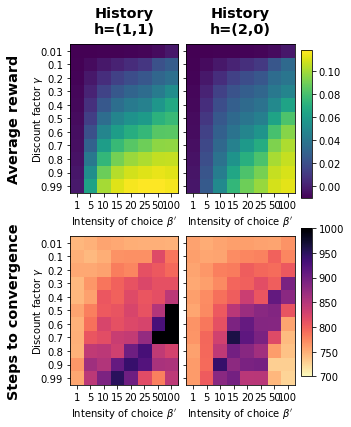

In [6]:
def plot_grid(df, what='rmean', ax=None, bar=False,
                  vmax=None, vmin=None, cmap='viridis'):
    
    dfus = df[what].astype(float).unstack()
    if ax is None:
        cbar = plt.imshow(dfus, vmax=vmax, vmin=vmin, cmap=cmap)
        ax = plt.gca()
    else:
        cbar = ax.imshow(dfus, vmax=vmax, vmin=vmin, cmap=cmap)
    ax.set_xticks(range(len(dfus.columns)))
    ax.set_xticklabels(list(dfus.columns))
    ax.set_xlabel(dfus.columns.name)
    ax.set_yticks(range(len(dfus.index)))
    ax.set_yticklabels(list(dfus.index))
    ax.set_ylabel(dfus.index.name)
    ax.set_title(what)

    ax.set_ylabel(r'Discount factor $\gamma$')
    ax.yaxis.labelpad = -4
    ax.set_xlabel(r"Intensity of choice $\beta'$")

    if bar:
        cb = plt.gcf().colorbar(cbar, ax=ax)
        return cb
    else:
        return cbar


fsf = 1.2
fig, axes = plt.subplots(2, 2, figsize=(fsf*4, fsf*5))

_     = plot_grid(dfPh1, 'rmean', vmin=-0.011, vmax=0.118, ax=axes[0,0])
cbar1 = plot_grid(dfPh2, 'rmean', vmin=-0.011, vmax=0.118, ax=axes[0,1])

_     = plot_grid(dfPh1, 'lmean', vmin=700, vmax=1000, cmap='magma_r',
                  ax=axes[1,0])
cbar2 = plot_grid(dfPh2, 'lmean', vmin=700, vmax=1000, cmap='magma_r',
                  ax=axes[1,1])

for ax in axes[:, 1]:
    ax.set_yticklabels([])
    ax.set_ylabel('')

for ax in axes.flatten():
    ax.set_title('')

# COLORBARS 
x = 0.87; dx= 0.03
# Colorbar 1
y = axes[0, 1].get_position().y0
dy = axes[0, 1].get_position().y1 - y
cax = fig.add_axes([x, y, dx, dy])
fig.colorbar(cbar1, cax=cax)

# Colorbar 2
y = axes[1, 1].get_position().y0
dy = axes[1, 1].get_position().y1 - y
cax = fig.add_axes([x, y, dx, dy])
fig.colorbar(cbar2, cax=cax)

# ANNOTATION

axes[0,0].annotate(f"History\nh=(1,1)", xy=(.5, 1.05), xycoords="axes fraction",
                   color="k", ha="center", va="bottom", fontsize='x-large',
                   weight='semibold')

axes[0,1].annotate(f"History\nh=(2,0)", xy=(.5, 1.05), xycoords="axes fraction",
                   color="k", ha="center", va="bottom", fontsize='x-large',
                   weight='semibold')
              
axes[0,0].annotate(f"Average reward", xy=(-0.45, 0.5), xycoords="axes fraction",
                   color="k", ha="right", va="center", fontsize='x-large',
                   weight='semibold', rotation=90)    

axes[1,0].annotate(f"Steps to convergence", xy=(-0.45, 0.5),
                   xycoords="axes fraction", color="k", ha="right", va="center",
                   fontsize='x-large', weight='semibold', rotation=90)  

plt.subplots_adjust(left=0.2, wspace=0.075, hspace=0.25, right=0.85, top=0.9,
                    bottom=0.1)

# plt.savefig('figs/fig_NaviHistory.png', dpi=300, facecolor='w')